# Debugging techniques

In this tutorial you will learn:

 - How to find issues in your model
 - How to debug a interrupted run
 - How to determine causes of slow-down
 - How to debug MPI parallelisation
 - How to check step sampler correctness


This tutorial allows you to make sure your code is good, independent of ultranest.

Lets start with the sine example from the ["Higher-dimensional fitting" tutorial](https://johannesbuchner.github.io/UltraNest/example-sine-highd.html):

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import ultranest
import corner

from numpy import sin, pi

def sine_model1(t, B, A1, P1, t1):
    return A1 * sin((t / P1 + t1) * 2 * pi) + B

np.random.seed(42)

n_data = 50

# time of observations
t = np.random.uniform(0, 5, size=n_data)
# measurement values
yerr = 1.0
y = np.random.normal(sine_model1(t, B=1.0, A1=4.2, P1=3, t1=0), yerr)


Probabilistic model implementation:

In [2]:
parameters = ['B', 'A1', 'P1', 't1']
ndim = len(parameters)

def prior_transform(cube):
    params = cube.copy()
    params[0] = cube[0] * 20 - 10
    params[1] = 10**(cube[1] * 3 - 1)
    params[2] = 10**(cube[1] * 2)
    params[3] = cube[3]
    return params

def log_likelihood(params):
    B, A1, P1, t1 = params
    y_model = sine_model1(t, B=B, A1=A1, P1=P1, t1=t1).tolist()
    return scipy.stats.norm(y_model, yerr).logpdf(y).sum()


## Finding model bugs

We have made a happy little mistake in the implementation above.

### Finding prior transform bugs

To find it, lets sample from the prior:

In [3]:
p = [prior_transform(np.random.uniform(size=ndim)) for i in range(1000)]

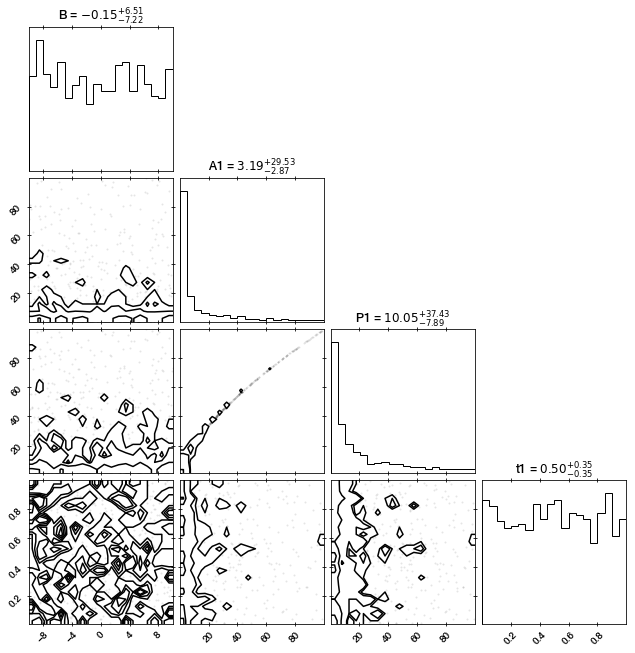

In [4]:
corner.corner(np.array(p), titles=parameters, show_titles=True, plot_density=False, quiet=True);

See the issue? A1 and P1 are perfectly correlated!

Here is the bug pointed out, and the corrected version:

In [5]:
def prior_transform(cube):
    params = cube.copy()
    params[0] = cube[0] * 20 - 10
    params[1] = 10**(cube[1] * 3 - 1)
    params[2] = 10**(cube[1] * 2)
    #      ^              ^ 
    #                     |
    #                  Mistake
    # correct version:
    params[2] = 10**(cube[2] * 2)
    params[3] = cube[3]
    return params

### Finding likelihood function bugs

Draw uniformly from the prior and plot the model. 

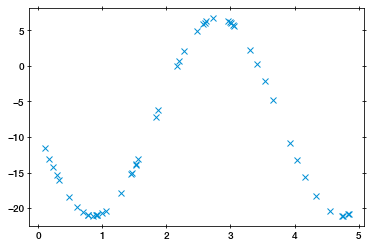

In [6]:
params = prior_transform(np.random.uniform(size=ndim))
plt.plot(t, sine_model1(t, *params), 'x ');

Repeat this a few times and you have prior predictive checks!

Also have a look at a few randomly drawn likelihood values. If you see values repeated, or infinites, it is not a good sign.

In [7]:
[log_likelihood(pi) for pi in p[:10]]

[-1961.2412862297433,
 -994.4041211269235,
 -2339.297354798619,
 -599.6818945970597,
 -1576.6457304537498,
 -145507.65589077197,
 -307.52989804045745,
 -291.9437786218507,
 -1333.029330033732,
 -1882.6914521041922]

## How can I make the inference go faster?

There are two categories of slowdowns:

1. Computational slow-downs: Your model is implemented so it is is slow to evaluate.
2. Algorithmic slow-downs: Your model is difficult and requires many model evaluations.

Lets find out which one is blocking you most:

### Measuring implementation speed


Lets measure the speed of our prior transform and model:

In [8]:
u = np.random.uniform(size=ndim)
%timeit prior_transform(u)

6.53 µs ± 256 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
p = prior_transform(u)
%timeit log_likelihood(p)

897 µs ± 6.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Here we see that the prior transform is very quick: one evaluation per microsecond. But the likelihood is much slower, with one  evaluation per ms. That means for a million samples, we already have to wait 15 minutes.

We should speed it up (see ["Higher-dimensional fitting" tutorial](https://johannesbuchner.github.io/UltraNest/example-sine-highd.html) for a faster implementation).

### Measuring algorithmic speed

In the ultranest output, look at the sampling efficiency.

If it is a few percent to 100%, the inference is very fast algorithmically, and you should focus on the model computation speed (see above). Switching to a step sampler will not lead to improvements.

If the efficiency is very low (say, 0.1% or lower), the proposal is inefficient. Use a step sampler (see ["Higher-dimensional fitting" tutorial](https://johannesbuchner.github.io/UltraNest/example-sine-highd.html)).

## Looking inside a interrupted run

Lets run ultranest for 30 seconds and interrupt it, and see the parameter space it is tackling.

In [10]:
import signal
def timeout_handler(signum, frame):
    raise TimeoutError()
old_handler = signal.signal(signal.SIGALRM, timeout_handler) 
signal.alarm(30);

In [11]:
import ultranest

sampler = ultranest.ReactiveNestedSampler(parameters, log_likelihood, prior_transform,
                                          wrapped_params=[False, False, False, True])

try:
    sampler.run()
except TimeoutError:
    print("run interrupted!")

signal.signal(signal.SIGALRM, old_handler);

[ultranest] Sampling 400 live points from prior ...


run interrupted!| Like=-255.66..-89.46 [-260.4596..-249.1400] | it/evals=2060/20807 eff=10.0946% N=400 0 0  


### Looking inside the current parameter space

Nested sampling is at this likelihood threshold:

In [12]:
sampler.Lmin

-255.4088047726119

Lets see the distribution of live points in the parameter space:

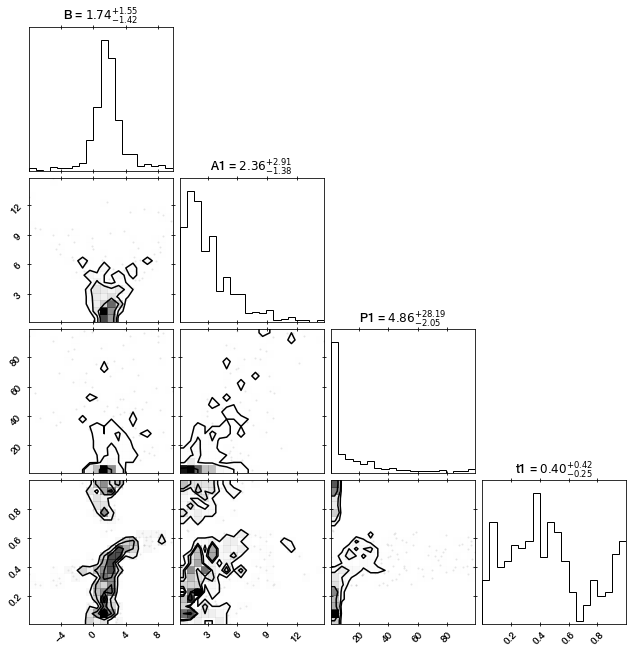

In [13]:
live_points_p = sampler.transform(sampler.region.u)
corner.corner(live_points_p, titles=sampler.paramnames, show_titles=True, quiet=True);

This does not look trivial, for example P1-t1 plot has two arms. It is not a ellipsoidal contour (which would be the easiest shape).

However, this plot also includes the prior deformation. What ultranest operates on, primarily, is the unit cube. Lets look at the live points distribution in the un-transformed prior space:

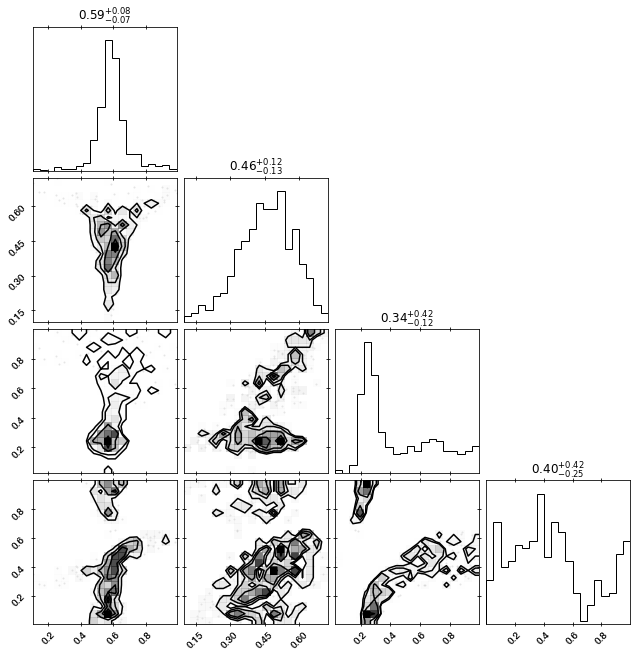

In [14]:
corner.corner(sampler.region.u, show_titles=True, quiet=True);

Again, you see relatively complicated shapes. This means that the parameters have a complicated relationship with the observables.

You can help ultranest by reparametrizing the parameters, or adding derived parameters, which are more ellipsoidal, and better behaved.

Lets see what models correspond to the current live points:

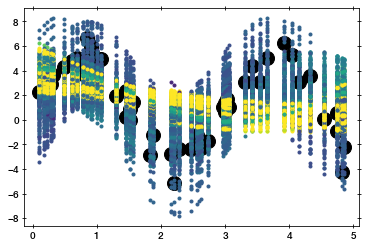

In [15]:
plt.plot(t, y, 'o ', ms=14, color='k')

for params in live_points_p:
    plt.plot(t, sine_model1(t, *params), '. ', color=plt.cm.viridis(params[2]/10))


Here you see two groups of curves, which are highlighted by color-coding by period.

Some models (blue) that have the period as in the data (black circles),
and some (yellow) just put a straight line through the data.


This explains the two arms in the distribution plots above as well.

### Reparametrizing

The sine curve model has the time shift t1 and the period as parameters. Likely, the data will constrain, for example, when the peak occurs, for example.

So you could add a derived parameter that specifies the time of the first peak. If that is closer to the data, the sampler can take advantage of it.

You can also see that when A1 is large, B can take a wider range of values, giving a funnel shape:

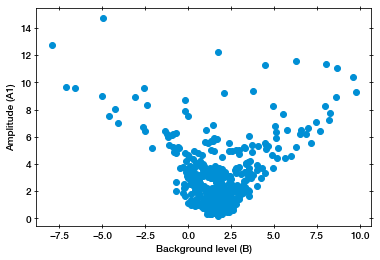

In [16]:
plt.scatter(live_points_p[:,0], live_points_p[:,1])
plt.ylabel('Amplitude (A1)')
plt.xlabel('Background level (B)');

This funnel is even clearer in unit cube space:

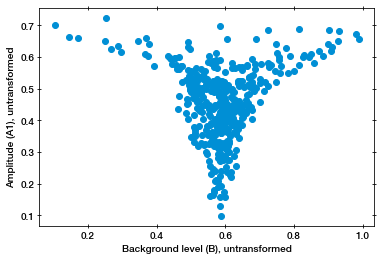

In [17]:
plt.scatter(sampler.region.u[:,0], sampler.region.u[:,1])
plt.ylabel('Amplitude (A1), untransformed')
plt.xlabel('Background level (B), untransformed');

A different parameterization would be to define a background fraction. Instead of background & amplitude being free parameters, you would have this reparametrized model:

In [18]:
parameters_reparametrized = ['Bfrac', 'A1', 'P1', 't1']

def prior_transform_reparametrized(cube):
    params = cube.copy()
    # amplitude:
    params[1] = 10**(cube[1] * 3 - 1)
    # background is scaled by params[1]
    params[0] = cube[0] * params[1]
    
    # rest is unchanged
    params[2] = 10**(cube[1] * 2)
    params[3] = cube[3]
    return params

This is only a toy example to give you ideas how to investigate the geometries the sampler is currently exploring.

## Parallelisation issues

If you have any MPI issues, test your MPI first in isolation, by running this command:

In [19]:
!mpiexec -np 4 python3 -c 'from mpi4py import MPI; print(MPI.COMM_WORLD.Get_rank(), MPI.COMM_WORLD.Get_size())'

This should give something like:

     3 4
     1 4
     0 4
     2 4

With the first column randomly. If it gives an output like the above, your MPI is working. If the last column is 1, your cores are not communicating. If you get an error, fix it first.

If you are seeing slower runtimes with MPI than without, see here: https://johannesbuchner.github.io/UltraNest/performance.html#parallelisation

Some MPI implementations have bugs, and you can switch to another MPI implementation. Your computing cluster admins may also help you with MPI troubles.

## Debugging step sampler quality

Run with nsteps=1, 2, 4, 8, 16, 32, 64 ... steps and look where the log(Z) value stabilizes.